# 2 Step Classification with RF & GB

Accuracy: 0.8443396226415094
Precision: 0.8445941699244529
Recall: 0.8443396226415094
F1 Score: 0.8428707521452213


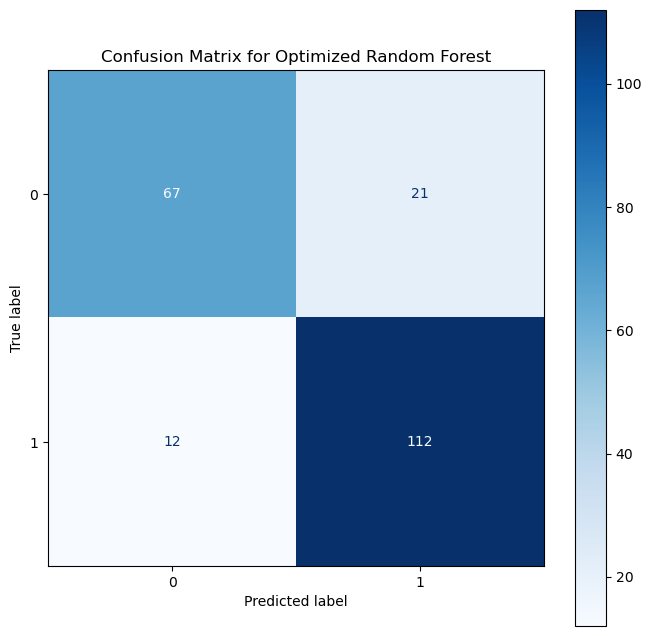

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Final_dataset_Classific.xlsx'
dataset = pd.read_excel(file_path)
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)
dataset = dataset.drop(columns='FIO2 eisagwgh_cleaned')
# Split the dataset into training and test sets
train_data, test_data = train_test_split(dataset, test_size=0.45, random_state=42)

# Prepare data for the first classification task
# This replaces all instances of class 2 with 0 for a simplified binary classification in Step 1
train_data['Outcome_numerical_step1'] = train_data['Outcome_numerical'].replace(2, 0)
X_train = train_data.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
y_train = train_data['Outcome_numerical_step1']

# Standardize features for Step 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the Random Forest Classifier for Step 1
optimized_rf = RandomForestClassifier(n_estimators=300, max_depth=9, min_samples_leaf=1,  min_samples_split=2, bootstrap=True, random_state=42)
optimized_rf.fit(X_train_scaled, y_train)

# Prepare the test set for Step 1 predictions
X_test = test_data.drop(columns=['Outcome_numerical'])
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set for Step 1
test_data['Predicted_step1'] = optimized_rf.predict(X_test_scaled)

# Define y_test for evaluating the performance of Step 1 predictions
y_test = test_data['Outcome_numerical'].replace(2, 0) 
y_pred_step1 = test_data['Predicted_step1']

# Calculate metrics
optimized_accuracy_rf = accuracy_score(y_test, y_pred_step1)
optimized_precision_rf = precision_score(y_test, y_pred_step1, average='weighted')
optimized_recall_rf = recall_score(y_test, y_pred_step1, average='weighted')
optimized_f1_rf = f1_score(y_test, y_pred_step1, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_step1)

print(f"Accuracy: {optimized_accuracy_rf}")
print(f"Precision: {optimized_precision_rf}")
print(f"Recall: {optimized_recall_rf}")
print(f"F1 Score: {optimized_f1_rf}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Random Forest')
plt.show()


Step 2 Accuracy: 0.569620253164557
Step 2 Precision: 0.5172413793103449
Step 2 Recall: 0.42857142857142855
Step 2 F1 Score: 0.46875000000000006


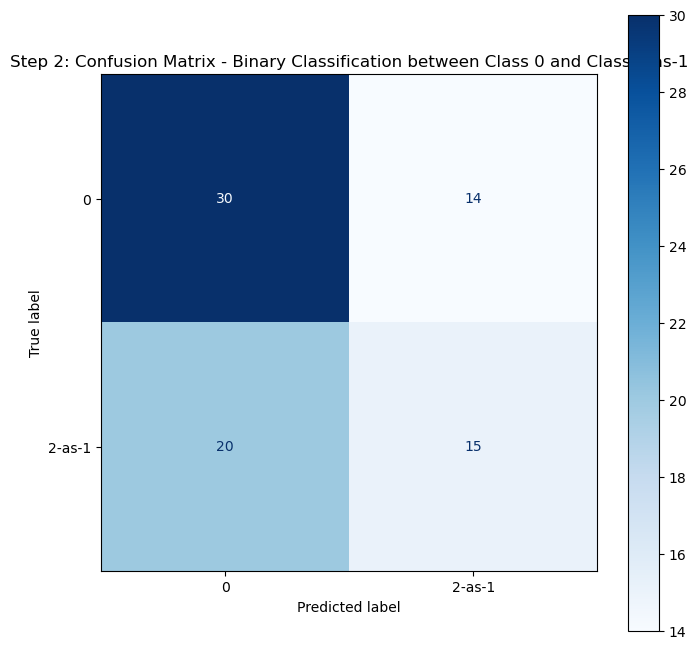

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# Step 2: Prepare the test set
test_data_step2 = test_data[test_data['Predicted_step1'] == 0]
X_test_step2 = test_data_step2.drop(columns=['Outcome_numerical', 'Predicted_step1'])
y_test_step2 = test_data_step2['Outcome_numerical'].replace(2, 1) 

# Prepare the training data for Step 2 (binary classification: class 0 vs class 2-as-1)
train_data_step2 = train_data[train_data['Outcome_numerical'] != 1]
X_train_step2 = train_data_step2.drop(columns=['Outcome_numerical', 'Outcome_numerical_step1'])
y_train_step2 = train_data_step2['Outcome_numerical'].replace(2, 1)

# Standardize features for Step 2
scaler_step2 = StandardScaler()
X_train_step2_scaled = scaler_step2.fit_transform(X_train_step2)

# Apply SMOTE for Step 2 to handle class imbalance
smote = SMOTE(random_state=42)
X_train_step2_smote, y_train_step2_smote = smote.fit_resample(X_train_step2_scaled, y_train_step2)


optimized_gb = GradientBoostingClassifier(
    learning_rate=1,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=4,
    n_estimators=500,
    subsample=0.6,
    random_state=42
)
optimized_gb.fit(X_train_step2_smote, y_train_step2_smote)

# Scale features for Step 2 in the test set
X_test_step2_scaled = scaler_step2.transform(X_test_step2)

# Make predictions for Step 2
y_pred_step2 = optimized_gb.predict(X_test_step2_scaled)
# Calculate and display evaluation metrics for Step 2
accuracy_step2 = accuracy_score(y_test_step2, y_pred_step2)
precision_step2 = precision_score(y_test_step2, y_pred_step2)
recall_step2 = recall_score(y_test_step2, y_pred_step2)
f1_step2 = f1_score(y_test_step2, y_pred_step2)

print(f"Step 2 Accuracy: {accuracy_step2}")
print(f"Step 2 Precision: {precision_step2}")
print(f"Step 2 Recall: {recall_step2}")
print(f"Step 2 F1 Score: {f1_step2}")

# Visualize the confusion matrix for Step 2
conf_matrix_step2 = confusion_matrix(y_test_step2, y_pred_step2)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_step2, display_labels=[0, '2-as-1'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Step 2: Confusion Matrix - Binary Classification between Class 0 and Class 2-as-1')
plt.show()


Final Model Accuracy: 0.7216981132075472
Final Model Precision: 0.6071385359951603
Final Model Recall: 0.6064720942140297
Final Model F1 Score: 0.6033253964913802


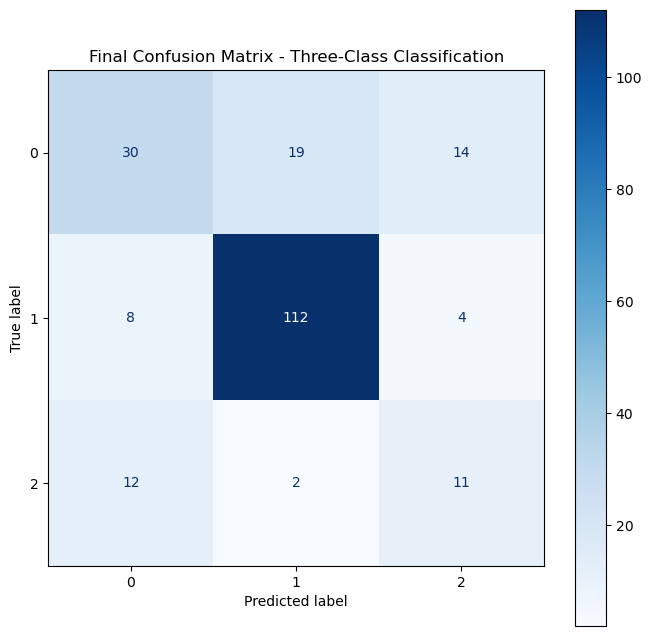

In [18]:
# Step 2 re-encoding needs to be reversed for the final classification:
# 0 remains 0, 1 (re-encoded class 2) needs to be turned back to 2
test_data.loc[test_data_step2.index, 'Predicted_step2'] = y_pred_step2
test_data.loc[test_data_step2.index, 'Predicted_step2'] = test_data['Predicted_step2'].replace(1, 2)

# Combine Step 1 and Step 2 predictions into a final classification result
def combine_predictions(row):
    if row['Predicted_step1'] == 1:
        return 1  # Direct classification as class 1
    else:
        return row['Predicted_step2']  # Either 0 or 2 as classified in Step 2

test_data['Final_Prediction'] = test_data.apply(combine_predictions, axis=1)

# Evaluation with the original classes
y_true = test_data['Outcome_numerical']  # Assuming this column has the original class labels
y_pred_final = test_data['Final_Prediction']

# Calculate and display evaluation metrics for the final three-class classification
accuracy_final = accuracy_score(y_true, y_pred_final)
precision_final = precision_score(y_true, y_pred_final, average='macro')
recall_final = recall_score(y_true, y_pred_final, average='macro')
f1_final = f1_score(y_true, y_pred_final, average='macro')

print(f"Final Model Accuracy: {accuracy_final}")
print(f"Final Model Precision: {precision_final}")
print(f"Final Model Recall: {recall_final}")
print(f"Final Model F1 Score: {f1_final}")

# Visualize the final confusion matrix
conf_matrix_final = confusion_matrix(y_true, y_pred_final)
fig, ax = plt.subplots(figsize=(8, 8))
disp_final = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=[0, 1, 2])
disp_final.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Final Confusion Matrix - Three-Class Classification')
plt.show()


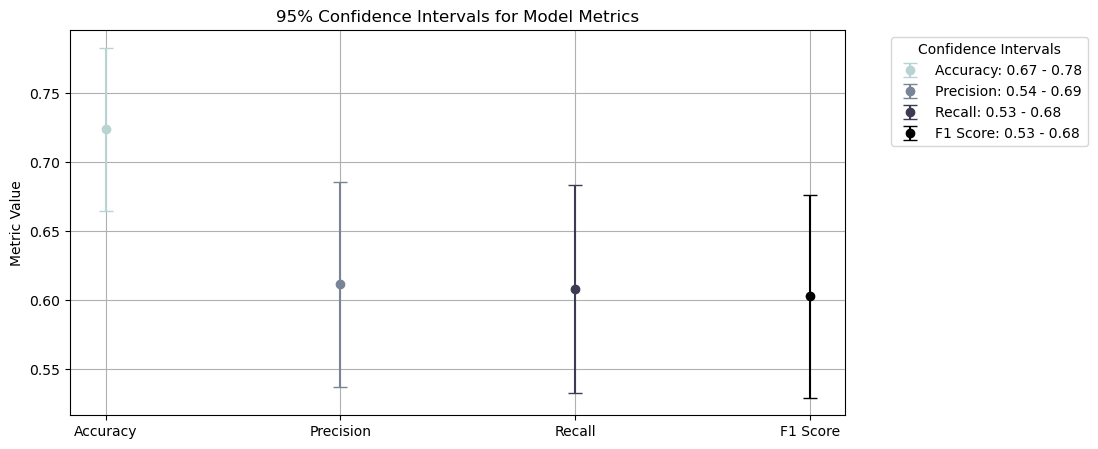

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Define the function to perform bootstrap and calculate confidence intervals
def bootstrap_confidence_intervals(y_true, y_pred, n_iterations=1000):
    # Metric storage arrays
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Perform bootstrap
    for _ in range(n_iterations):
        # Generate indices for the bootstrap sample
        indices = resample(np.arange(len(y_true)), replace=True)
        # Sample true values and predictions based on bootstrap indices
        y_true_sample = y_true.iloc[indices]
        y_pred_sample = y_pred.iloc[indices]

        # Calculate metrics for this sample
        accuracies.append(accuracy_score(y_true_sample, y_pred_sample))
        precisions.append(precision_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        recalls.append(recall_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))
        f1_scores.append(f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))

    # Calculate 95% confidence intervals for each metric
    metrics = {
        "Accuracy": np.percentile(accuracies, [2.5, 97.5]),
        "Precision": np.percentile(precisions, [2.5, 97.5]),
        "Recall": np.percentile(recalls, [2.5, 97.5]),
        "F1 Score": np.percentile(f1_scores, [2.5, 97.5])
    }

    return metrics

# Call the function with the final predictions
ci_results = bootstrap_confidence_intervals(test_data['Outcome_numerical'], test_data['Final_Prediction'])

# Plotting the confidence intervals
fig, ax = plt.subplots(figsize=(10, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
ci_bounds = [ci_results[metric] for metric in metrics]
colors = plt.cm.bone_r(np.linspace(0.2, 1, len(metrics)))

for idx, (metric, ci) in enumerate(zip(metrics, ci_bounds)):
    mean = np.mean([ci[0], ci[1]])
    error = [(mean - ci[0], ci[1] - mean)]
    ax.errorbar(x=metric, y=mean, yerr=np.array(error).T,
                fmt='o', color=colors[idx], label=f'{metric}: {ci[0]:.2f} - {ci[1]:.2f}', capsize=5)

ax.set_title('95% Confidence Intervals for Model Metrics')
ax.set_ylabel('Metric Value')
ax.legend(title="Confidence Intervals", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


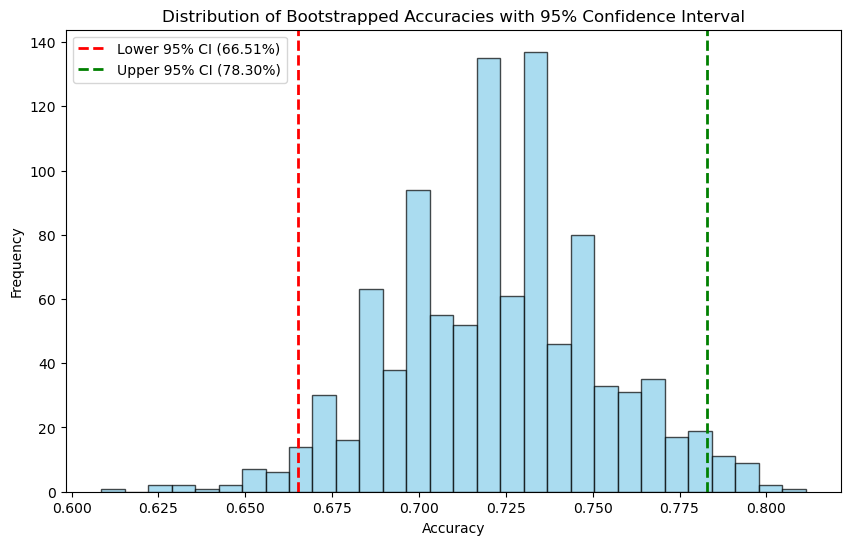

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

def bootstrap_accuracies(y_true, y_pred, n_iterations=1000):
    accuracies = []
    for _ in range(n_iterations):
        # Generate indices for the bootstrap sample
        indices = resample(np.arange(len(y_true)), replace=True)
        # Sample true values and predictions based on bootstrap indices
        y_true_sample = y_true.iloc[indices]
        y_pred_sample = y_pred.iloc[indices]
        # Calculate accuracy for this sample
        accuracies.append(accuracy_score(y_true_sample, y_pred_sample))
    return accuracies

# Perform the bootstrap
bootstrap_accuracies = bootstrap_accuracies(test_data['Outcome_numerical'], test_data['Final_Prediction'])

# Calculate 95% confidence intervals
confidence_lower = np.percentile(bootstrap_accuracies, 2.5)
confidence_upper = np.percentile(bootstrap_accuracies, 97.5)

# Plotting the distribution of bootstrapped accuracies
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(confidence_lower, color='red', linestyle='dashed', linewidth=2, label=f'Lower 95% CI ({confidence_lower:.2%})')
plt.axvline(confidence_upper, color='green', linestyle='dashed', linewidth=2, label=f'Upper 95% CI ({confidence_upper:.2%})')

plt.title('Distribution of Bootstrapped Accuracies with 95% Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


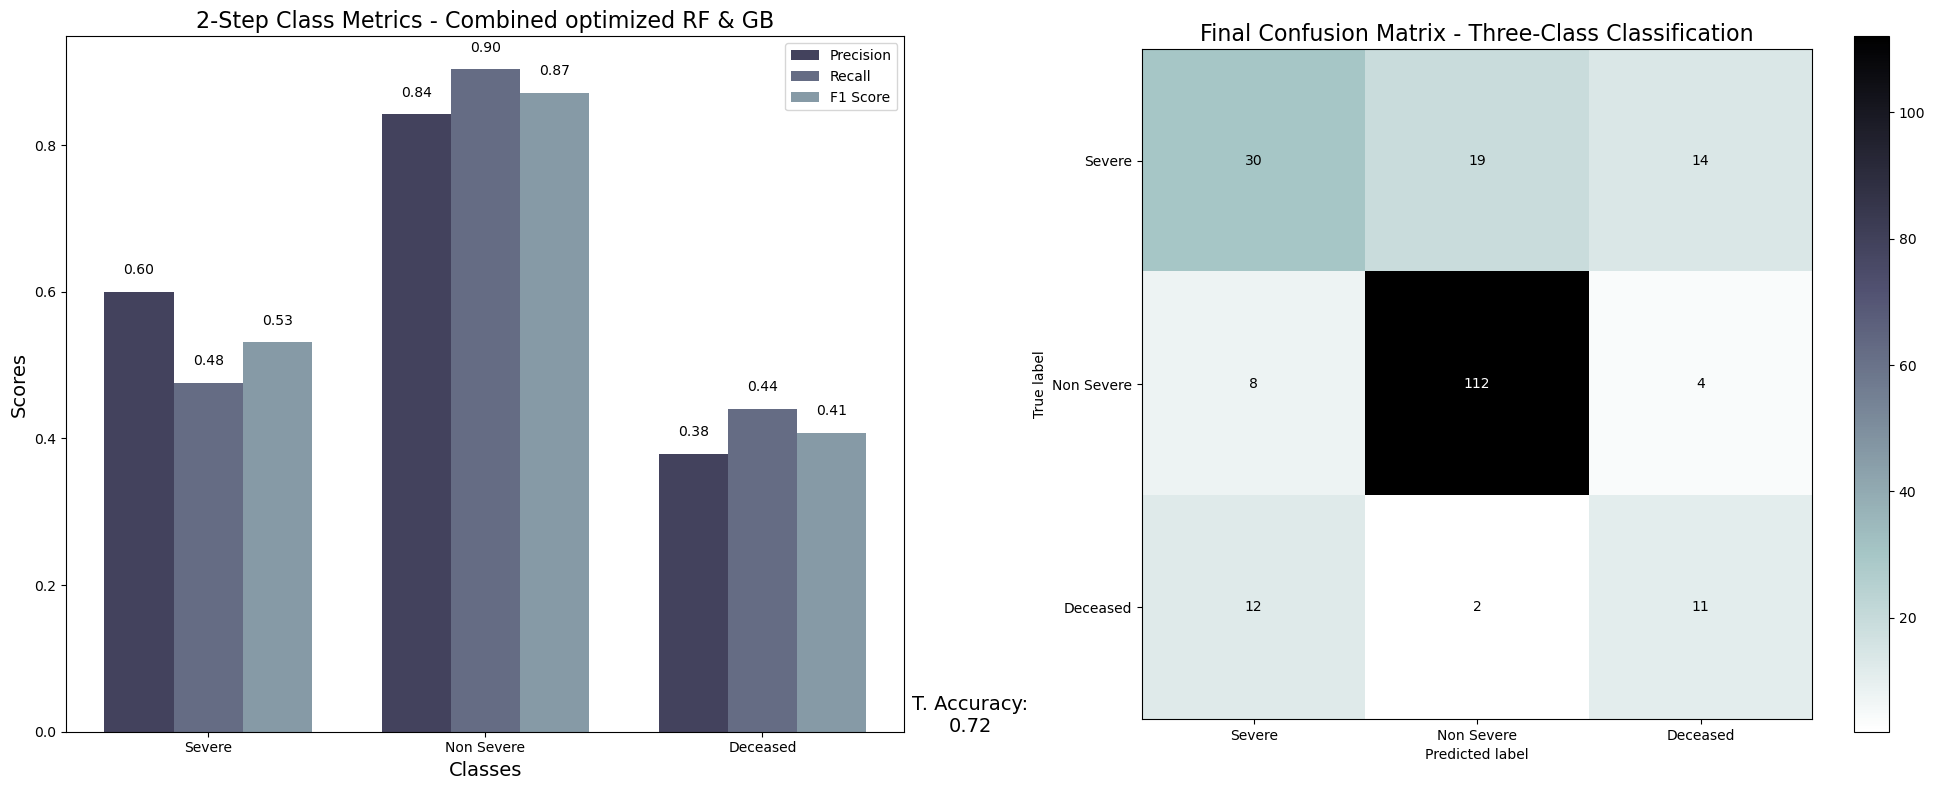

In [ ]:
# Calculate and display evaluation metrics for the final three-class classification
accuracy_final = accuracy_score(y_true, y_pred_final)
precision_final = precision_score(y_true, y_pred_final, average=None)  # Changed to None for individual class scores
recall_final = recall_score(y_true, y_pred_final, average=None) 
f1_final = f1_score(y_true, y_pred_final, average=None)
conf_matrix_final = confusion_matrix(y_true, y_pred_final)

class_labels = ['Severe', 'Non Severe', 'Deceased']

# Creating a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Color palette

bar_width = 0.25
index = np.arange(len(class_labels))

# Plotting precision, recall, and F1-score for each class
axes[0].bar(index, precision_final, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, recall_final, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, f1_final, bar_width, color=bone_palette[2], label='F1 Score')

# Setting labels and titles
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('2-Step Class Metrics - Combined optimized RF & GB', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for clarity
for i in range(len(class_labels)):
    axes[0].text(i, precision_final[i] + 0.02, f'{precision_final[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + bar_width, recall_final[i] + 0.02, f'{recall_final[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + 2 * bar_width, f1_final[i] + 0.02, f'{f1_final[i]:.2f}', ha='center', va='bottom')

axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{accuracy_final:.2f}', fontsize=14, ha='center')
# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Final Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()


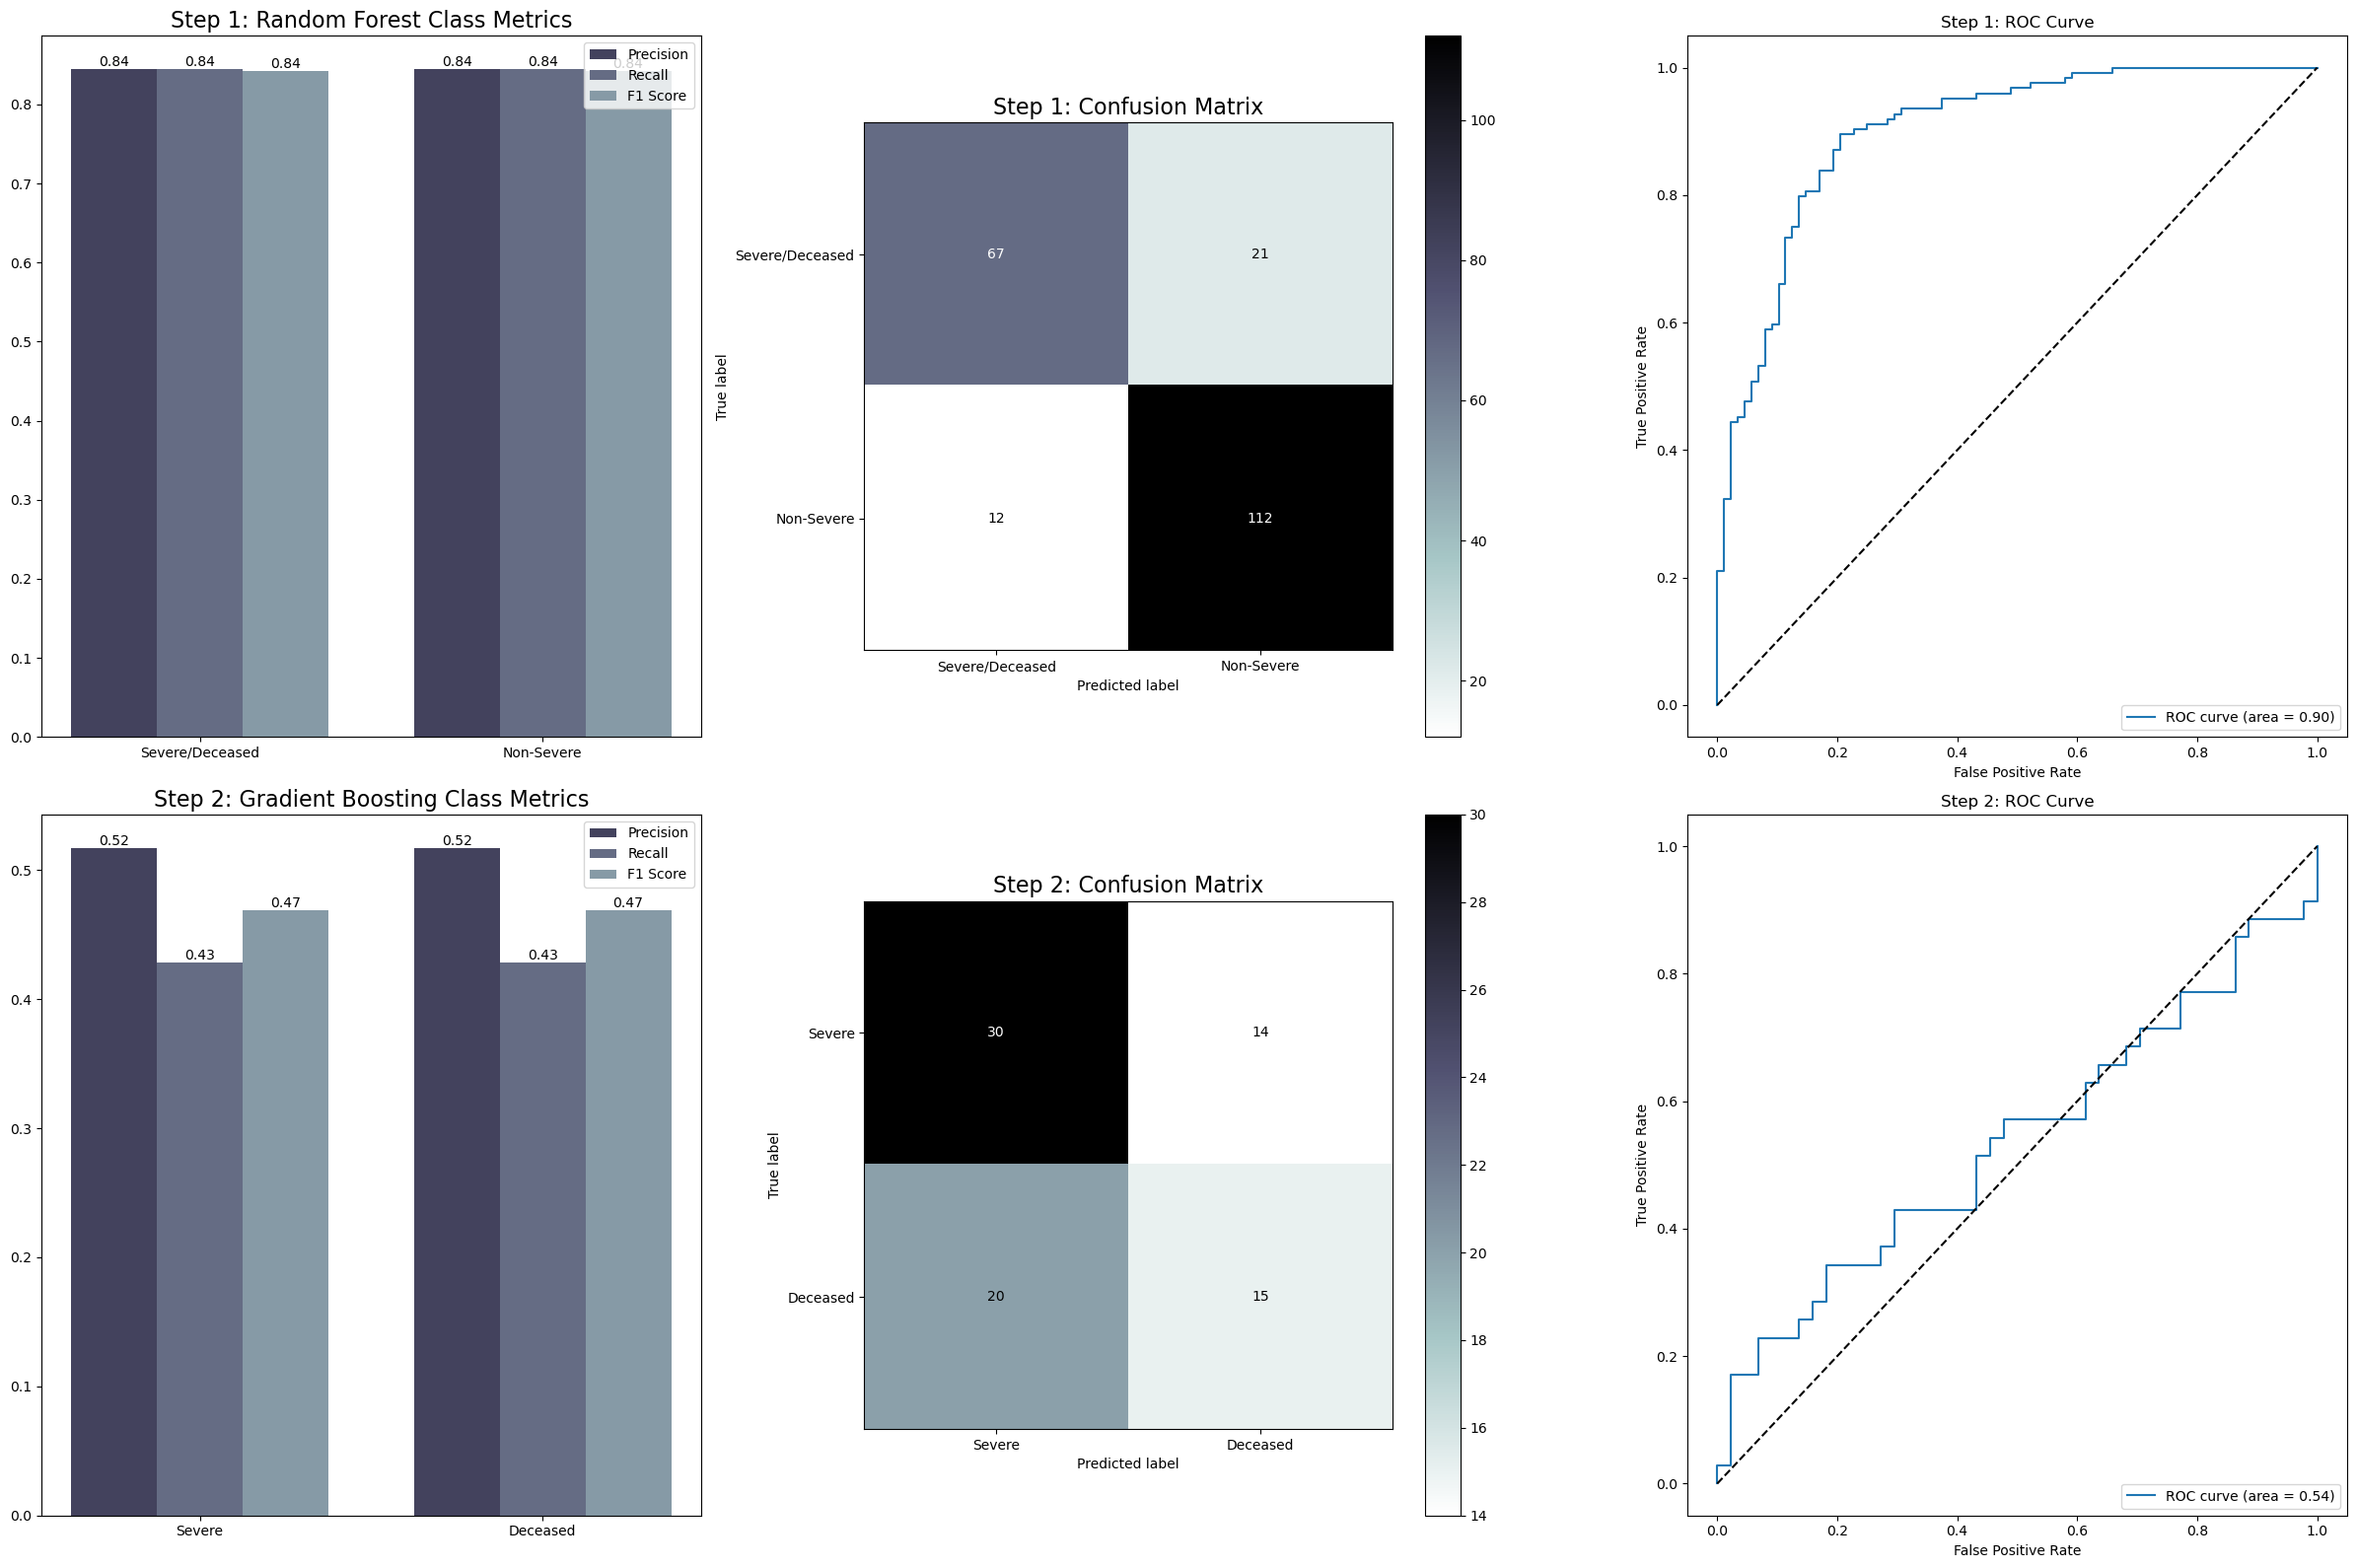

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
import numpy as np
# Calculate metrics
optimized_accuracy_rf = accuracy_score(y_test, y_pred_step1)
optimized_precision_rf = precision_score(y_test, y_pred_step1, average='weighted')
optimized_recall_rf = recall_score(y_test, y_pred_step1, average='weighted')
optimized_f1_rf = f1_score(y_test, y_pred_step1, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_step1)
# Define metrics arrays if not already defined
metrics_step1 = [optimized_precision_rf, optimized_recall_rf, optimized_f1_rf ]  # Arrays of precision, recall, and f1 for each class in step 1
metrics_step2 = [precision_step2, recall_step2, f1_step2]  # Similar for step 2
class_labels_step1 = ['Severe/Deceased', 'Non-Severe']  # Update these labels based on your classes
class_labels_step2 = ['Severe', 'Deceased']  # Update these labels based on your classes

# Calculate AUC-ROC for both steps
y_scores_step1 = optimized_rf.predict_proba(X_test_scaled)[:, 1]  # Assuming you have probabilities for the positive class
fpr_step1, tpr_step1, _ = roc_curve(y_test.replace(2, 0), y_scores_step1)  # Ensure y_test is appropriately modified for binary class
roc_auc_step1 = auc(fpr_step1, tpr_step1)

y_scores_step2 = optimized_gb.predict_proba(X_test_step2_scaled)[:, 1]  # Assuming class 2 probabilities are treated as the positive class
fpr_step2, tpr_step2, _ = roc_curve(y_test_step2, y_scores_step2)
roc_auc_step2 = auc(fpr_step2, tpr_step2)

# Setting up the subplot layout
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Plot metrics for Step 1
bar_width = 0.25
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))
for i, metric in enumerate(metrics_step1):
    bars = axes[0, 0].bar(np.arange(len(class_labels_step1)) + i * bar_width, metric, color=bone_palette[i], width=bar_width, label=['Precision', 'Recall', 'F1 Score'][i])
    for bar in bars:
        yval = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

axes[0, 0].set_title('Step 1: Random Forest Class Metrics', fontsize=16)
axes[0, 0].set_xticks(np.arange(len(class_labels_step1)) + bar_width)
axes[0, 0].set_xticklabels(class_labels_step1)
axes[0, 0].legend()

# Confusion Matrix for Step 1
disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=class_labels_step1)
disp1.plot(cmap=plt.cm.bone_r, ax=axes[0, 1])
axes[0, 1].set_title('Step 1: Confusion Matrix', fontsize=16)

# ROC Curve for Step 1
axes[0, 2].plot(fpr_step1, tpr_step1, label=f'ROC curve (area = {roc_auc_step1:.2f})')
axes[0, 2].plot([0, 1], [0, 1], 'k--')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('Step 1: ROC Curve')
axes[0, 2].legend(loc="lower right")

# Plot metrics for Step 2
for i, metric in enumerate(metrics_step2):
    bars = axes[1, 0].bar(np.arange(len(class_labels_step2)) + i * bar_width, metric, color=bone_palette[i], width=bar_width, label=['Precision', 'Recall', 'F1 Score'][i])
    for bar in bars:
        yval = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

axes[1, 0].set_title('Step 2: Gradient Boosting Class Metrics', fontsize=16)
axes[1, 0].set_xticks(np.arange(len(class_labels_step2)) + bar_width)
axes[1, 0].set_xticklabels(class_labels_step2)
axes[1, 0].legend()

# Confusion Matrix for Step 2
disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_step2, display_labels=class_labels_step2)
disp2.plot(cmap=plt.cm.bone_r, ax=axes[1, 1])
axes[1, 1].set_title('Step 2: Confusion Matrix', fontsize=16)

# ROC Curve for Step 2
axes[1, 2].plot(fpr_step2, tpr_step2, label=f'ROC curve (area = {roc_auc_step2:.2f})')
axes[1, 2].plot([0, 1], [0, 1], 'k--')
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].set_title('Step 2: ROC Curve')
axes[1, 2].legend(loc="lower right")

plt.tight_layout()
plt.show()


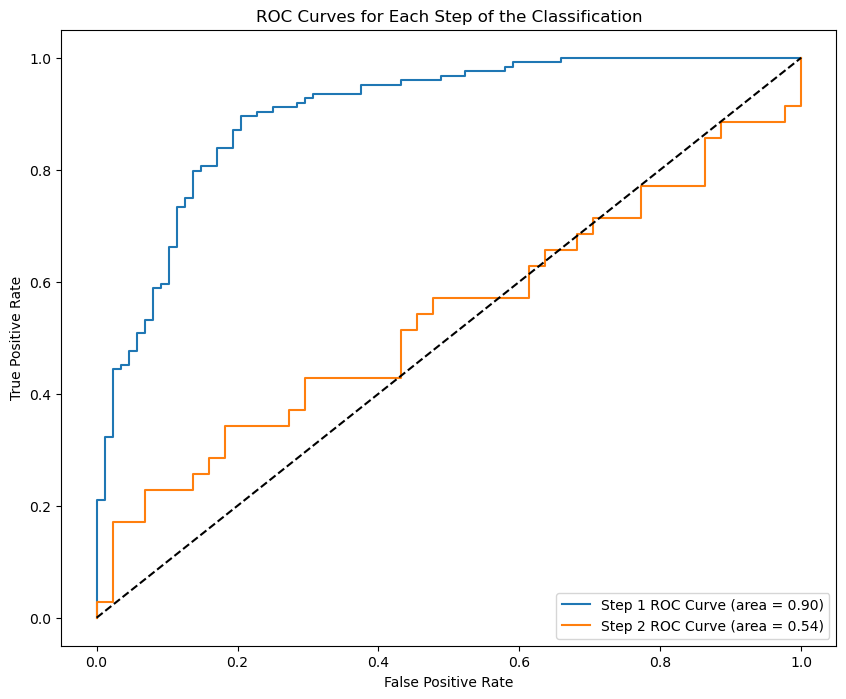

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities for the positive class (assuming binary classification)
y_scores_step1 = optimized_rf.predict_proba(X_test_scaled)[:, 1]  # for the class considered as 'positive'
fpr_step1, tpr_step1, _ = roc_curve(y_test, y_scores_step1)  # Assuming y_test is already binary
roc_auc_step1 = auc(fpr_step1, tpr_step1)

# Step 2: Get predicted probabilities for the positive class (considering the re-encoded class)
y_scores_step2 = optimized_gb.predict_proba(X_test_step2_scaled)[:, 1]
fpr_step2, tpr_step2, _ = roc_curve(y_test_step2, y_scores_step2)
roc_auc_step2 = auc(fpr_step2, tpr_step2)

# Plot both ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_step1, tpr_step1, label=f'Step 1 ROC Curve (area = {roc_auc_step1:.2f})')
plt.plot(fpr_step2, tpr_step2, label=f'Step 2 ROC Curve (area = {roc_auc_step2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Step of the Classification')
plt.legend(loc='lower right')
plt.show()


In [ ]:
mean_auc = (roc_auc_step1 + roc_auc_step2) / 2
print("Mean AUC:", mean_auc)

Mean AUC: 0.7184161604524508


divide by zero encountered in divide
invalid value encountered in multiply


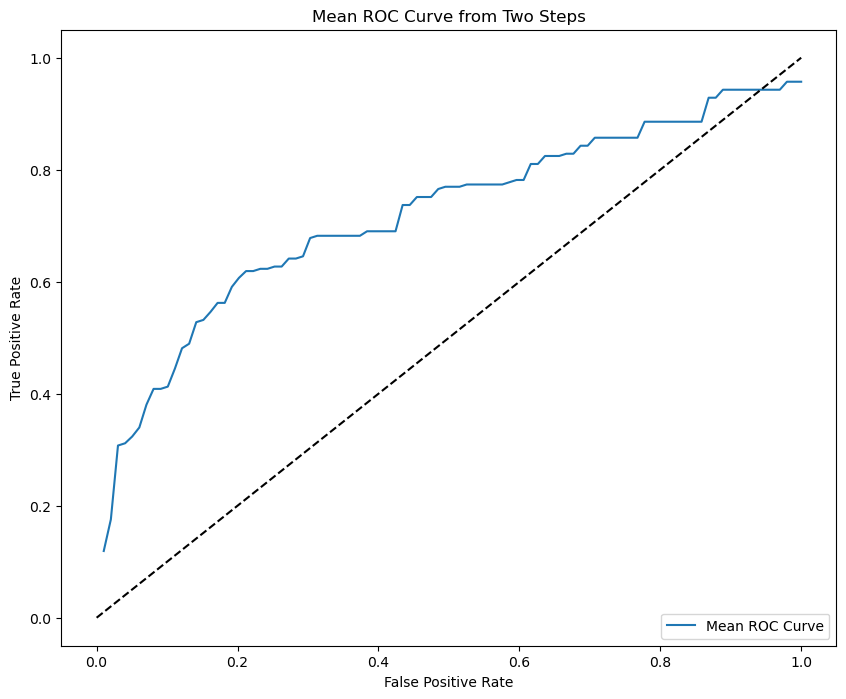

In [25]:
from scipy.interpolate import interp1d
import numpy as np

# Define common false positive rate points where you want to evaluate the ROC
common_fpr = np.linspace(0, 1, 100)

# Interpolation functions for each ROC curve
interp_tpr_step1 = interp1d(fpr_step1, tpr_step1, kind='linear', fill_value="extrapolate")
interp_tpr_step2 = interp1d(fpr_step2, tpr_step2, kind='linear', fill_value="extrapolate")

# Interpolated true positive rates at common false positive rates
tpr_step1_common = interp_tpr_step1(common_fpr)
tpr_step2_common = interp_tpr_step2(common_fpr)

# Mean true positive rate
mean_tpr = (tpr_step1_common + tpr_step2_common) / 2

# Plotting the mean ROC curve
plt.figure(figsize=(10, 8))
plt.plot(common_fpr, mean_tpr, label='Mean ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve from Two Steps')
plt.legend(loc='lower right')
plt.show()


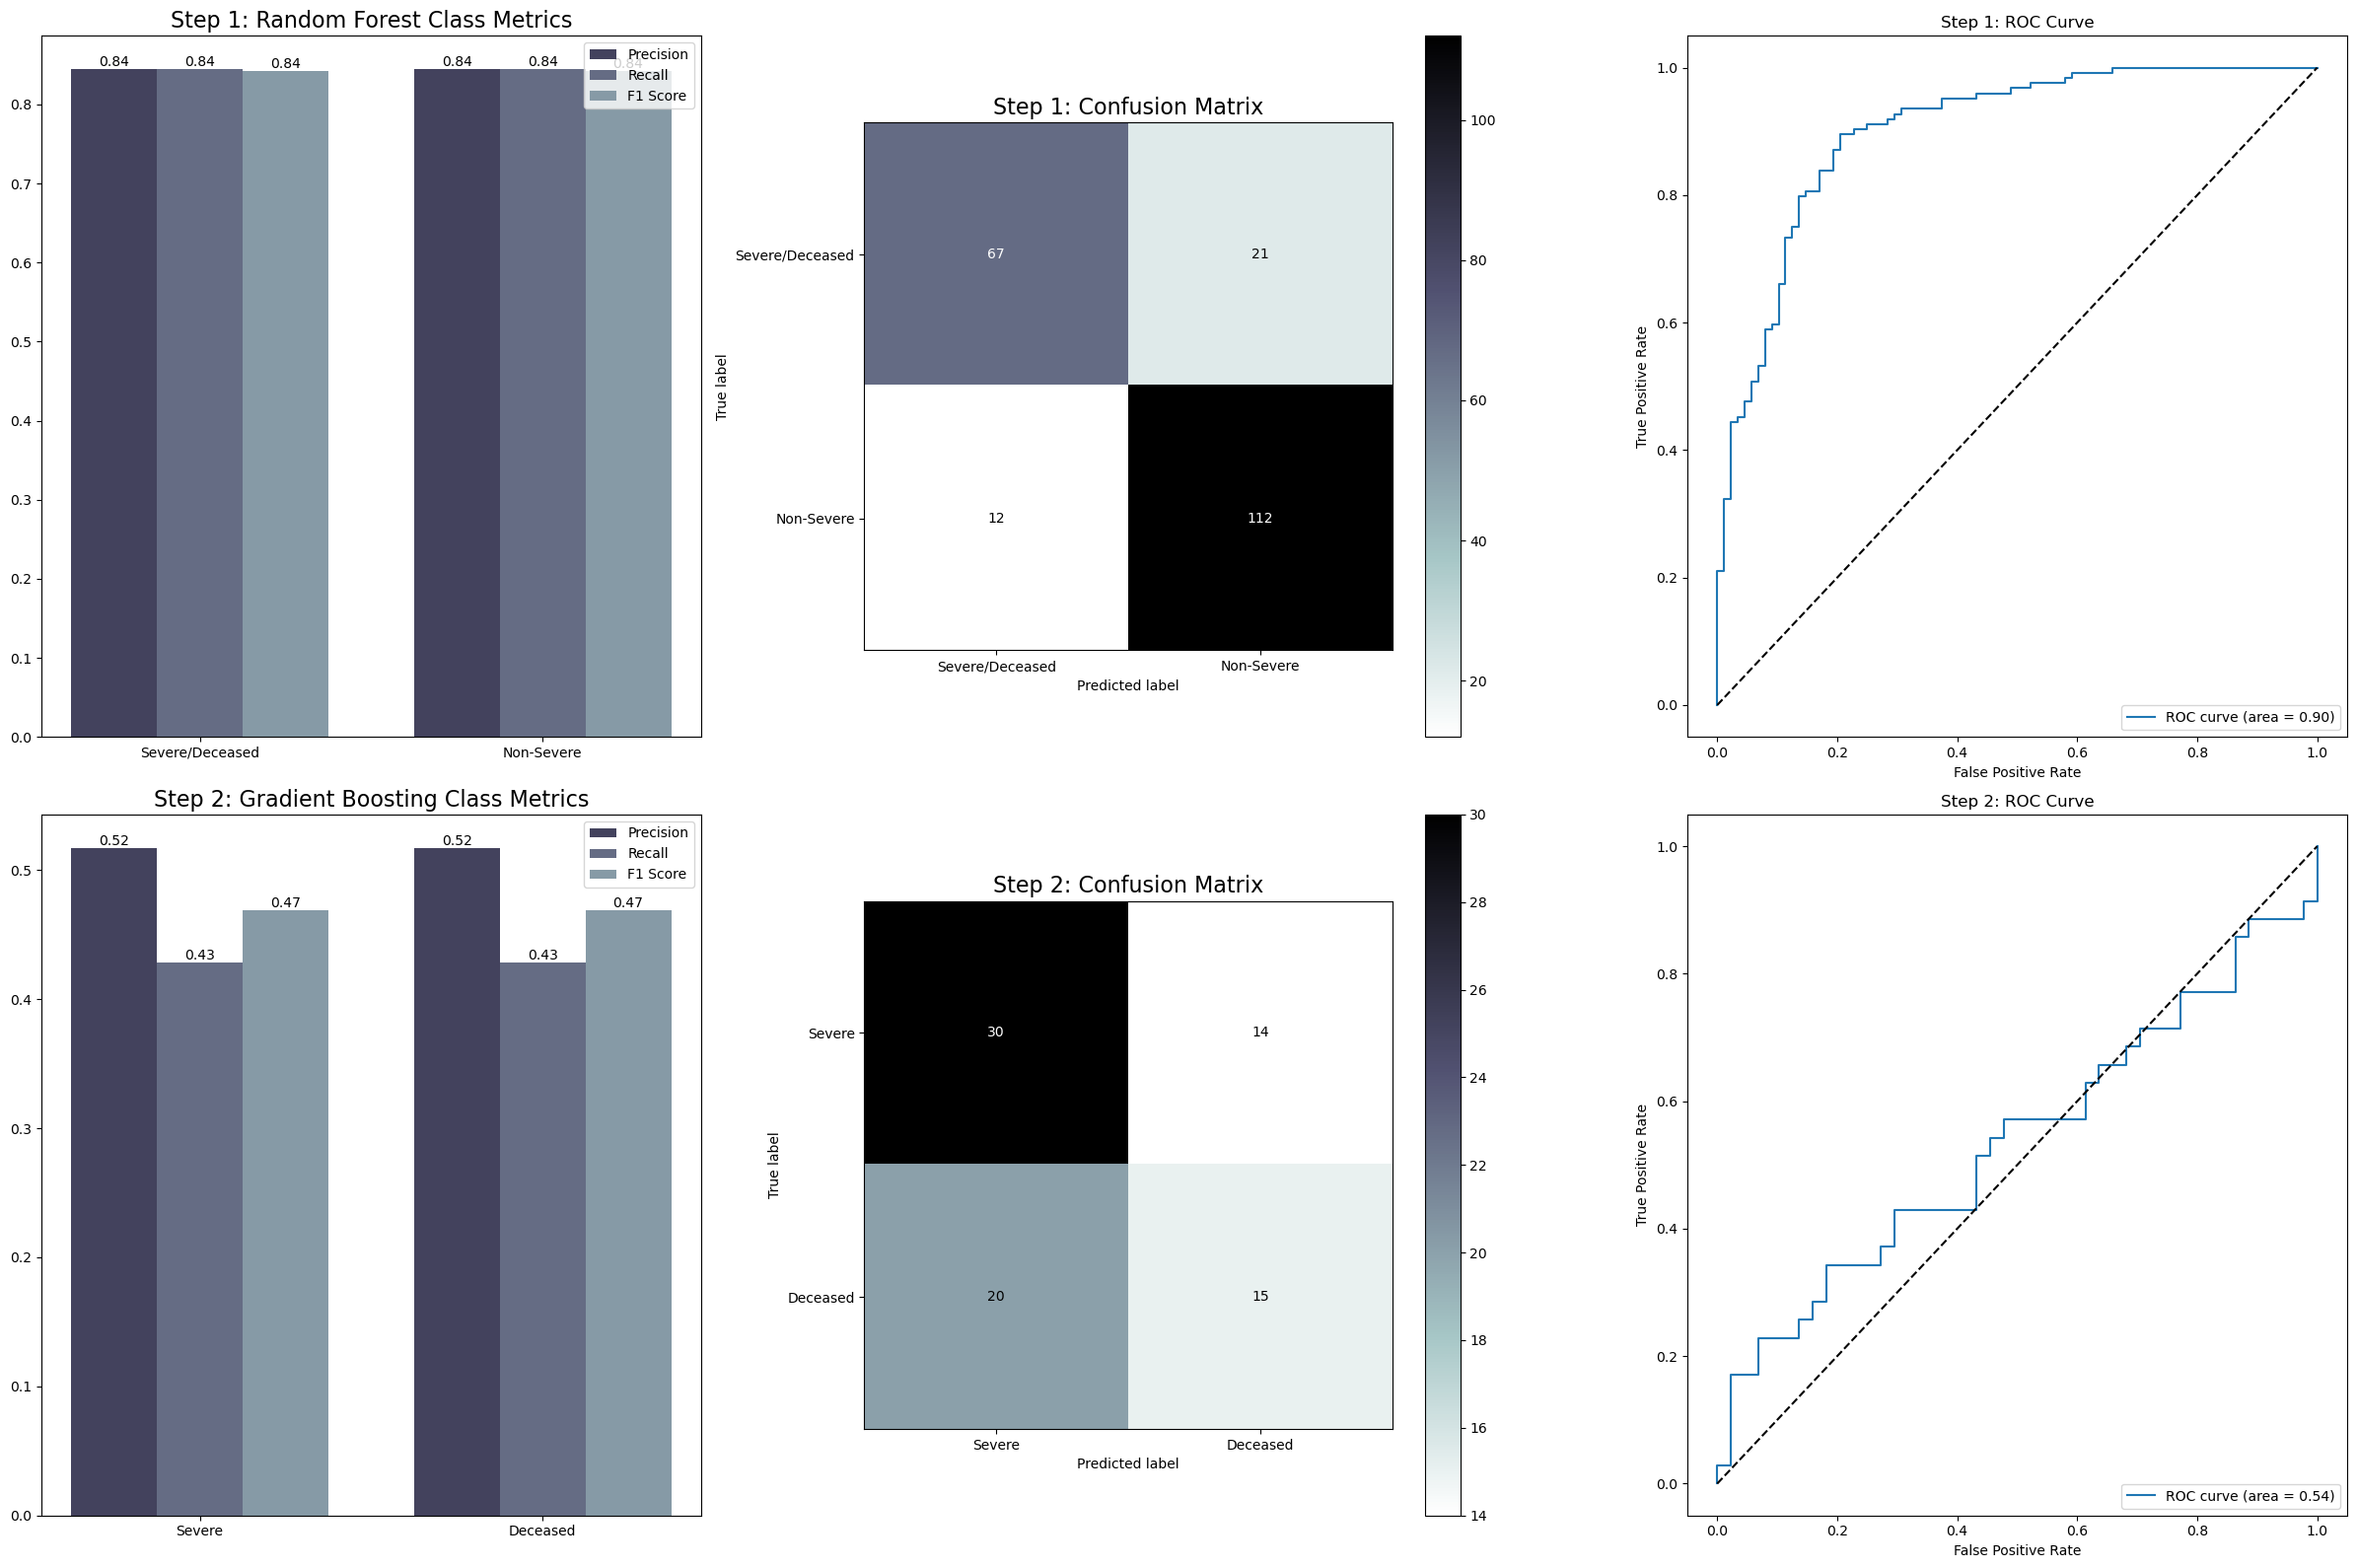

In [ ]:
# Calculate metrics
optimized_accuracy_rf = accuracy_score(y_test, y_pred_step1)
optimized_precision_rf = precision_score(y_test, y_pred_step1, average='weighted')
optimized_recall_rf = recall_score(y_test, y_pred_step1, average='weighted')
optimized_f1_rf = f1_score(y_test, y_pred_step1, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_step1)
metrics_step1 = [optimized_precision_rf, optimized_recall_rf, optimized_f1_rf ]  # Arrays of precision, recall, and f1 for each class in step 1
metrics_step2 = [precision_step2, recall_step2, f1_step2]  # Similar for step 2
class_labels_step1 = ['Severe/Deceased', 'Non-Severe']  # Update these labels based on your classes
class_labels_step2 = ['Severe', 'Deceased']  # Update these labels based on your classes

# Calculate AUC-ROC for both steps
y_scores_step1 = optimized_rf.predict_proba(X_test_scaled)[:, 1]  # Assuming you have probabilities for the positive class
fpr_step1, tpr_step1, _ = roc_curve(y_test.replace(2, 0), y_scores_step1)  # Ensure y_test is appropriately modified for binary class
roc_auc_step1 = auc(fpr_step1, tpr_step1)

y_scores_step2 = optimized_gb.predict_proba(X_test_step2_scaled)[:, 1]  # Assuming class 2 probabilities are treated as the positive class
fpr_step2, tpr_step2, _ = roc_curve(y_test_step2, y_scores_step2)
roc_auc_step2 = auc(fpr_step2, tpr_step2)

# Setting up the subplot layout
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

# Plot metrics for Step 1
bar_width = 0.25
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))
for i, metric in enumerate(metrics_step1):
    bars = axes[0, 0].bar(np.arange(len(class_labels_step1)) + i * bar_width, metric, color=bone_palette[i], width=bar_width, label=['Precision', 'Recall', 'F1 Score'][i])
    for bar in bars:
        yval = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

axes[0, 0].set_title('Step 1: Random Forest Class Metrics', fontsize=16)
axes[0, 0].set_xticks(np.arange(len(class_labels_step1)) + bar_width)
axes[0, 0].set_xticklabels(class_labels_step1)
axes[0, 0].legend()

# Confusion Matrix for Step 1
disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=class_labels_step1)
disp1.plot(cmap=plt.cm.bone_r, ax=axes[0, 1])
axes[0, 1].set_title('Step 1: Confusion Matrix', fontsize=16)

# ROC Curve for Step 1
axes[0, 2].plot(fpr_step1, tpr_step1, label=f'ROC curve (area = {roc_auc_step1:.2f})')
axes[0, 2].plot([0, 1], [0, 1], 'k--')
axes[0, 2].set_xlabel('False Positive Rate')
axes[0, 2].set_ylabel('True Positive Rate')
axes[0, 2].set_title('Step 1: ROC Curve')
axes[0, 2].legend(loc="lower right")

# Plot metrics for Step 2
for i, metric in enumerate(metrics_step2):
    bars = axes[1, 0].bar(np.arange(len(class_labels_step2)) + i * bar_width, metric, color=bone_palette[i], width=bar_width, label=['Precision', 'Recall', 'F1 Score'][i])
    for bar in bars:
        yval = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

axes[1, 0].set_title('Step 2: Gradient Boosting Class Metrics', fontsize=16)
axes[1, 0].set_xticks(np.arange(len(class_labels_step2)) + bar_width)
axes[1, 0].set_xticklabels(class_labels_step2)
axes[1, 0].legend()

# Confusion Matrix for Step 2
disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_step2, display_labels=class_labels_step2)
disp2.plot(cmap=plt.cm.bone_r, ax=axes[1, 1])
axes[1, 1].set_title('Step 2: Confusion Matrix', fontsize=16)

# ROC Curve for Step 2
axes[1, 2].plot(fpr_step2, tpr_step2, label=f'ROC curve (area = {roc_auc_step2:.2f})')
axes[1, 2].plot([0, 1], [0, 1], 'k--')
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].set_title('Step 2: ROC Curve')
axes[1, 2].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [27]:
import shap
shap.initjs()
# Initialize SHAP explainers
explainers = {
    'Random Forest': shap.TreeExplainer(optimized_rf),
    'GBoost': shap.TreeExplainer(optimized_gb)
}

shap_values = {
    name: explainer.shap_values(X_test)
    for name, explainer in explainers.items()
}


Model: Random Forest


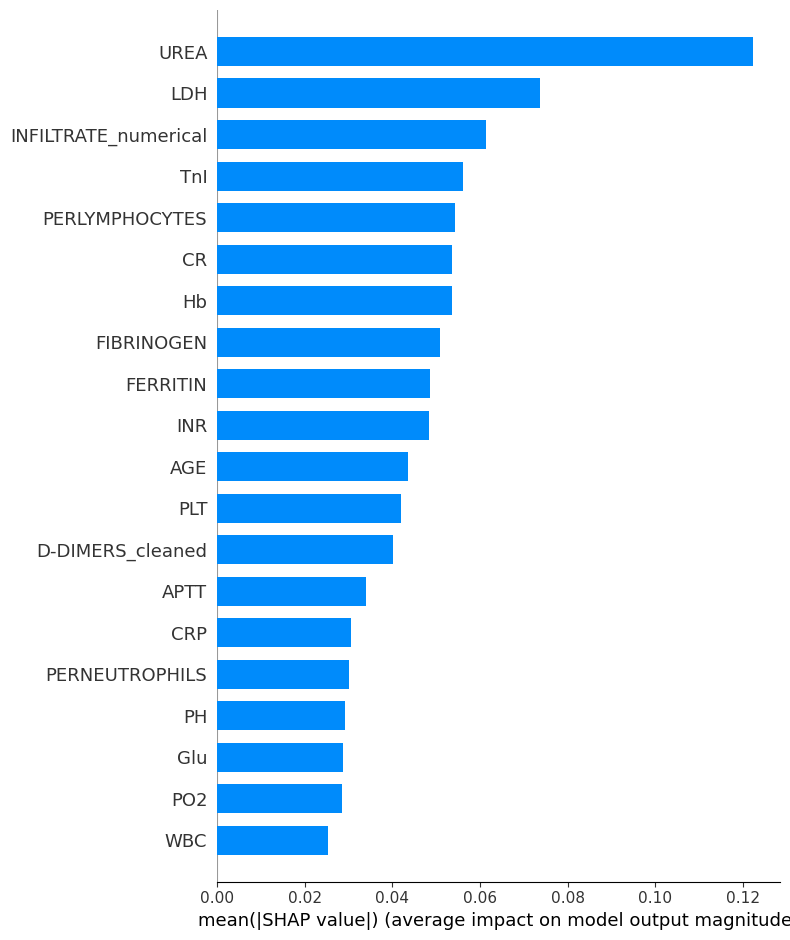

Model: GBoost


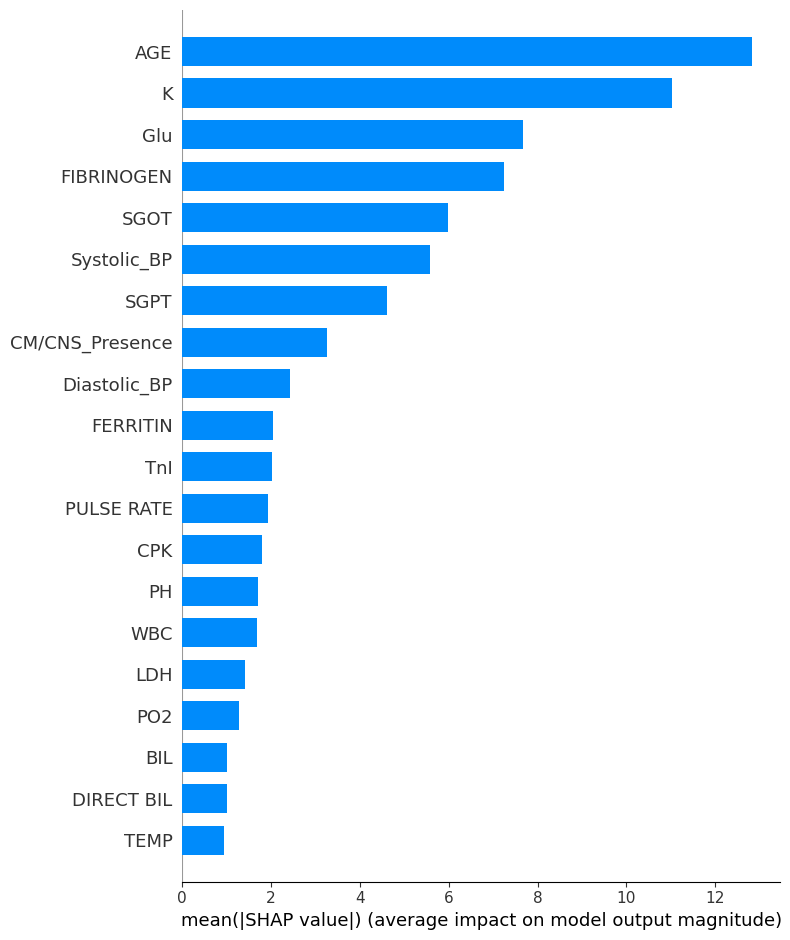

In [ ]:
# Visualization
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    # Check if SHAP values are in multi-class format (list of arrays)
    if isinstance(model_shap_values, list):  # Handling multi-class scenarios
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.sum(np.abs(model_shap_values), axis=0)  # Sum across classes, maintaining the sample-feature structure
    else:
        # Use directly if already in the correct format
        values_aggregated = model_shap_values
    
    # Ensure we have a 2D array for the summary plot
    if len(values_aggregated.shape) == 1:
        continue
    
    # Now plotting with the aggregated (summed across classes) SHAP values
    shap.summary_plot(values_aggregated, X_test, plot_type="bar", feature_names=X_test.columns, max_display=20)


Model: Random Forest


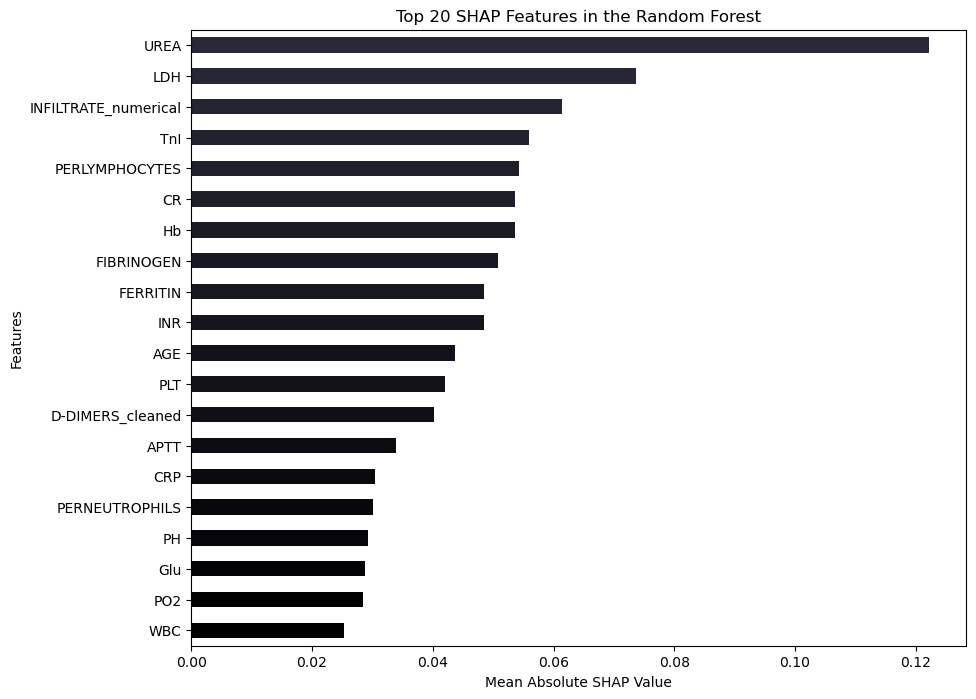

Model: GBoost


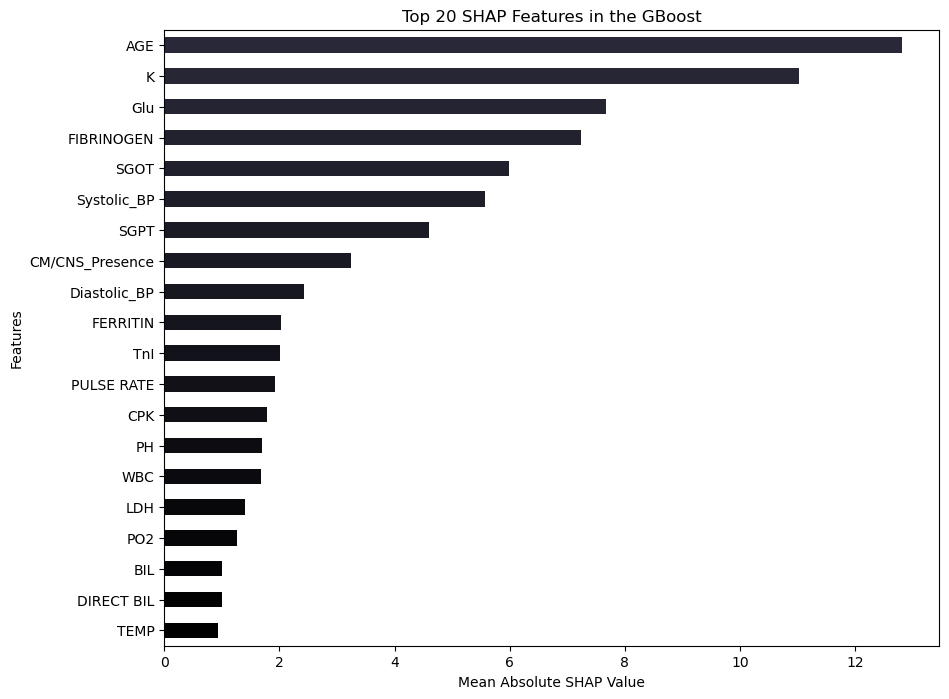

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X_sample' contains the feature data corresponding to 'shap_values'
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    if isinstance(model_shap_values, list):
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.abs(np.array(model_shap_values)).sum(axis=0).mean(axis=0)  # Mean absolute SHAP values per feature
    else:
        # Use directly if already in the correct format (mean absolute values)
        values_aggregated = np.abs(model_shap_values).mean(axis=0)

    # Create a Series for easy plotting, ensuring feature names align
    importances = pd.Series(values_aggregated, index=X_test.columns).sort_values(ascending=True)

    # Plotting in a similar style to your example
    plt.figure(figsize=(10, 8))
    bone_colors = plt.cm.bone(np.linspace(0, 1, len(importances)))
    importances.tail(20).plot(kind='barh', color=bone_colors)
    plt.title(f'Top 20 SHAP Features in the {model_name}')
    plt.xlabel('Mean Absolute SHAP Value')
    plt.ylabel('Features')
    plt.gca()
    plt.show()
